# NLP Disaster Tweets Project

Our goal is to solve a Natural Language Processing (NLP) problem of predicting whether tweets describe real disasters. 

The challenge of this problem is that people may use words in their tweets that describe a disaster, but are not describing a real disaster. To solve this problem, we use the DistilBert model, which is a pre-trained deep learning model that understands the contextual meaning of text. 

We first preprocessed the text, including conversion to lowercase, word splitting, deactivation, and stemming extraction, and then trained and predicted with the DistilBert model. Finally, we use the confusion matrix to evaluate the performance of the model and submit the predictions to the competition platform. We hope this brief will help you understand our problem and solution.

In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.2 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


2024-04-26 00:22:53.181627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 00:22:53.181728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 00:22:53.347909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


The selected backend is TensorFlow, while pyTorch can also be selected.

In [2]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.15.0
KerasNLP version: 0.9.3


## EDA

### Data Importing

In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


### Data Preprocessing

Creating instances of stop words and stemming extractors

In [4]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

Pre-processing procedures:

- Changing letters to lower case
- remove stop words

In [5]:
def preprocess_text(text):
    text = text.lower()
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

In [6]:
df_train["text"] = df_train["text"].apply(preprocess_text)
df_test["text"] = df_test["text"].apply(preprocess_text)

df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean       77.905425
std        28.700947
min         4.000000
25%        58.000000
50%        80.000000
75%       101.000000
max       143.000000
Name: length, dtype: float64
Test Length Stat
count    3263.000000
mean       79.222188
std        28.988327
min         4.000000
25%        59.000000
50%        82.000000
75%       102.000000
max       143.000000
Name: length, dtype: float64


### Data Visualization

Histogram of Tweet Length

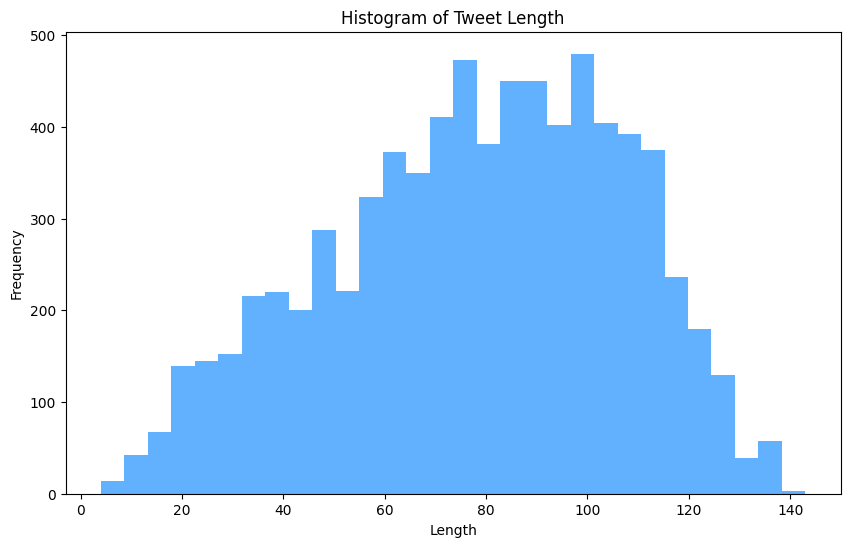

In [7]:
import matplotlib.pyplot as plt

# Histogram of Tweet Length
plt.figure(figsize=(10, 6))
plt.hist(df_train['length'], bins=30, alpha=0.7, color='dodgerblue')
plt.title('Histogram of Tweet Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

Pie Chart of Disaster vs Non-disaster Tweets

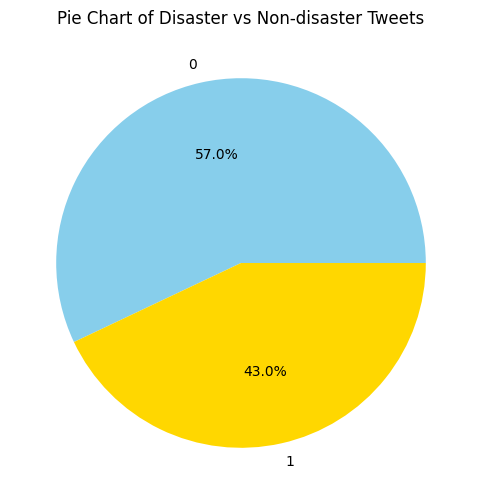

In [8]:
plt.figure(figsize=(6, 6))
df_train['target'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'gold'])
plt.title('Pie Chart of Disaster vs Non-disaster Tweets')
plt.ylabel('')
plt.show()

Average Tweet Length of Disaster vs Non-disaster

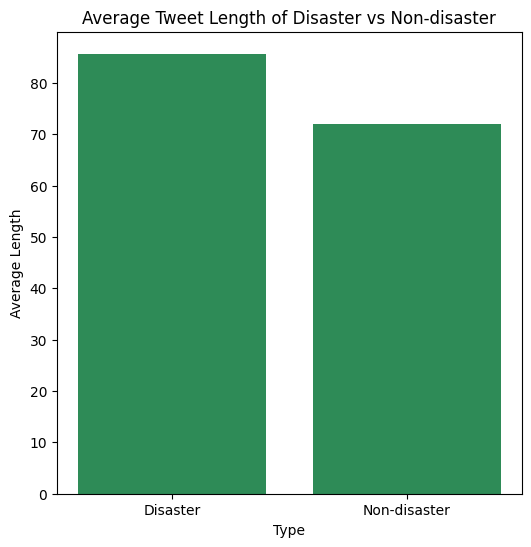

In [9]:
avg_len_disaster = df_train[df_train['target'] == 1]['length'].mean()
avg_len_non_disaster = df_train[df_train['target'] == 0]['length'].mean()

plt.figure(figsize=(6, 6))
plt.bar(['Disaster', 'Non-disaster'], [avg_len_disaster, avg_len_non_disaster], color='seagreen')
plt.title('Average Tweet Length of Disaster vs Non-disaster')
plt.xlabel('Type')
plt.ylabel('Average Length')
plt.show()

## Model Params

Will use the DistilBert model.

In [10]:
BATCH_SIZE = 64
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

## Model Training



Divide the data into a training set and a validation set.

In [11]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

We use Keras Core, the multi-backend version of Keras for model building.

Load a DistilBERT model, make the sequences shorter through preprocessor, and finally get a pretrained classifier for final compile and fit process.

In [12]:
preset= "distil_bert_base_en_uncased"
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,preprocessor = preprocessor,num_classes=2)

classifier.summary()

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val))

Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:93: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


I0000 00:00:1714091041.957379     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714091042.111281     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 [==============================] - ETA: 0s - loss: 0.5694 - accuracy: 0.7200

W0000 00:00:1714091135.063678     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714091139.270612     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714091147.775319     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 [==============================] - 141s 1s/step - loss: 0.5694 - accuracy: 0.7200 - val_loss: 0.4524 - val_accuracy: 0.8017
Epoch 2/3
96/96 [==============================] - 90s 934ms/step - loss: 0.4389 - accuracy: 0.8128 - val_loss: 0.4262 - val_accuracy: 0.8207
Epoch 3/3
96/96 [==============================] - 89s 927ms/step - loss: 0.3916 - accuracy: 0.8412 - val_loss: 0.4277 - val_accuracy: 0.8201


### Evaluation

We can have a more direct visualization about the model quality.

In [13]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


  2/191 [..............................] - ETA: 23s  

W0000 00:00:1714091384.206698     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 [==============================] - 34s 161ms/step


W0000 00:00:1714091414.765072     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


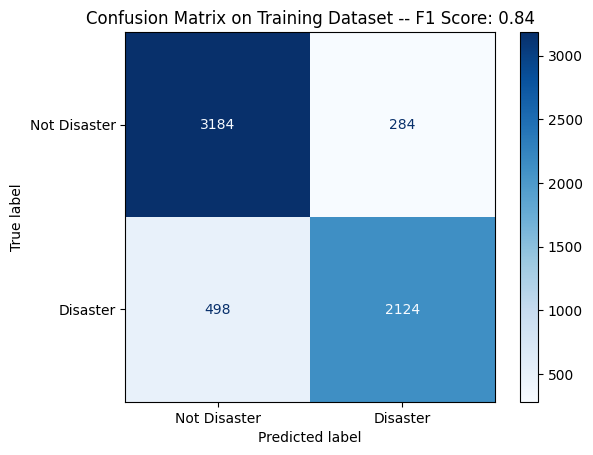

In [14]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 [==============================] - 10s 199ms/step


W0000 00:00:1714091425.900913     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


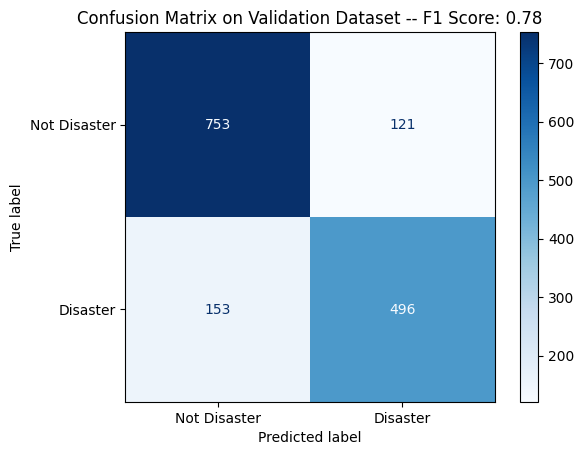

In [15]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

191/191 [==============================] - 30s 154ms/step
Training Accuracy: 0.87
Training Precision: 0.88
Training Recall: 0.81
Training F1 Score: 0.84
48/48 [==============================] - 8s 161ms/step
Validation Accuracy: 0.82
Validation Precision: 0.80
Validation Recall: 0.76
Validation F1 Score: 0.78


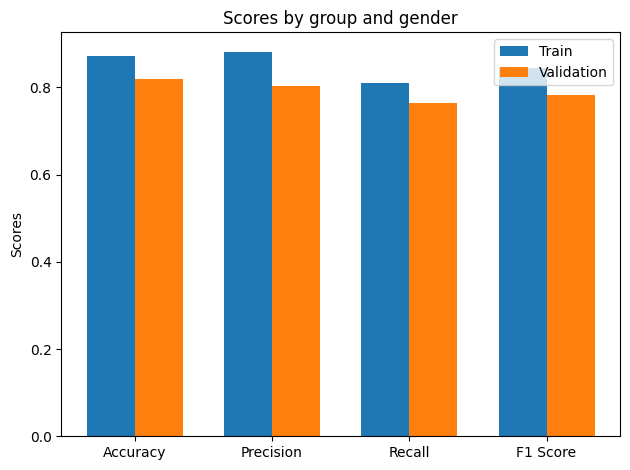

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_train2 = np.argmax(classifier.predict(X_train), axis=1)

accuracy_train = accuracy_score(y_train, y_pred_train2)
precision_train = precision_score(y_train, y_pred_train2)
recall_train = recall_score(y_train, y_pred_train2)
f1_train = f1_score(y_train, y_pred_train2)

print('Training Accuracy: {:.2f}'.format(accuracy_train))
print('Training Precision: {:.2f}'.format(precision_train))
print('Training Recall: {:.2f}'.format(recall_train))
print('Training F1 Score: {:.2f}'.format(f1_train))

y_pred_val2 = np.argmax(classifier.predict(X_val), axis=1)

accuracy_val = accuracy_score(y_val, y_pred_val2)
precision_val = precision_score(y_val, y_pred_val2)
recall_val = recall_score(y_val, y_pred_val2)
f1_val = f1_score(y_val, y_pred_val2)

print('Validation Accuracy: {:.2f}'.format(accuracy_val))
print('Validation Precision: {:.2f}'.format(precision_val))
print('Validation Recall: {:.2f}'.format(recall_val))
print('Validation F1 Score: {:.2f}'.format(f1_val))


metrics_train = [accuracy_train, precision_train, recall_train, f1_train]
metrics_val = [accuracy_val, precision_val, recall_val, f1_val]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics_train, width, label='Train')
rects2 = ax.bar(x + width/2, metrics_val, width, label='Validation')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


## Prediction Output

And print the output to file.

In [16]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

sample_submission.to_csv("submission.csv", index=False)

102/102 [==============================] - 18s 173ms/step


W0000 00:00:1714091445.636563     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Conclusion

In this project, we successfully solved a natural language processing (NLP) problem of predicting whether tweets describe real disasters. 

We first performed a series of preprocessing steps on the tweets, including conversion to lowercase, word splitting, deactivation, and stemming extraction, in order to allow the model to better understand the meaning of the text. 

We then trained and predicted using the DistilBert model, a powerful pre-trained deep learning model that understands the contextual meaning of the text to effectively distinguish between tweets describing real disasters and those that are not. 

During the model training and prediction process, we also use a confusion matrix to evaluate the model's performance and ensure that our model can accurately predict real disaster tweets. 

Finally, we completed the project by submitting our predictions to the competition platform. Overall, this project demonstrates how deep learning techniques can be used to solve real-world NLP problems and provides a valuable reference for future related research and applications.

The selected backend is TensorFlow, while pyTorch can also be selected.